In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

print(torch.cuda.is_available())


True


In [26]:
from matplotlib import collections
import matplotlib as mpl
def plot_mesh(data, mesh, ax,
              cmap=plt.cm.viridis,
              vmin=None, vmax=None,
              colorbar=True,
              colorbar_title=""):

    # Dolfin mesh, stores values on vertices not faces
    coords = mesh.coordinates().T
    cells = mesh.cells().T
    values = data[cells].mean(axis=0)

    xmin, ymin = coords.min(axis=1)
    xmax, ymax = coords.max(axis=1)

    polygons = coords[:, cells]
    polygons = np.moveaxis(polygons, (0, 1, 2), (2, 1, 0))
    col = collections.PolyCollection(polygons)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    col.set_color(cmap(norm(values)))
    ax.add_collection(col)
    ax.set(xlim=[xmin, xmax],
           ylim=[ymin, ymax])
    ax.set_aspect(1)

    if colorbar:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        vmin, vmax = sm.get_clim()
        vmean = (vmin + vmax)/2
        cax = ax.inset_axes([1.05, 0, 0.05, 1])
        cbar = plt.colorbar(sm, cax=cax, ax=ax,
                            ticks=[vmin, vmean, vmax])
        cbar.ax.set_ylabel(colorbar_title, rotation=-90)

def plot_grid(data, coords, ax,
              cmap=plt.cm.viridis,
              vmin=None, vmax=None,
              colorbar=True,
              colorbar_title=""):
    xmin, ymin = coords[0].min(), coords[1].min()
    xmax, ymax = coords[0].max(), coords[1].max()

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.pcolormesh(coords[0], coords[1], data, norm=norm, cmap=cmap)
    ax.set(xlim=[xmin, xmax],
           ylim=[ymin, ymax])
    ax.set_aspect(1)

    if colorbar:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        vmin, vmax = sm.get_clim()
        vmean = (vmin + vmax)/2
        cax = ax.inset_axes([1.05, 0, 0.05, 1])
        cbar = plt.colorbar(sm, cax=cax, ax=ax,
                            ticks=[vmin, vmean, vmax])
        cbar.ax.set_ylabel(colorbar_title, rotation=-90)

Loss with random inputs: 0.000433
Loss with assigned force: 1.75e-11


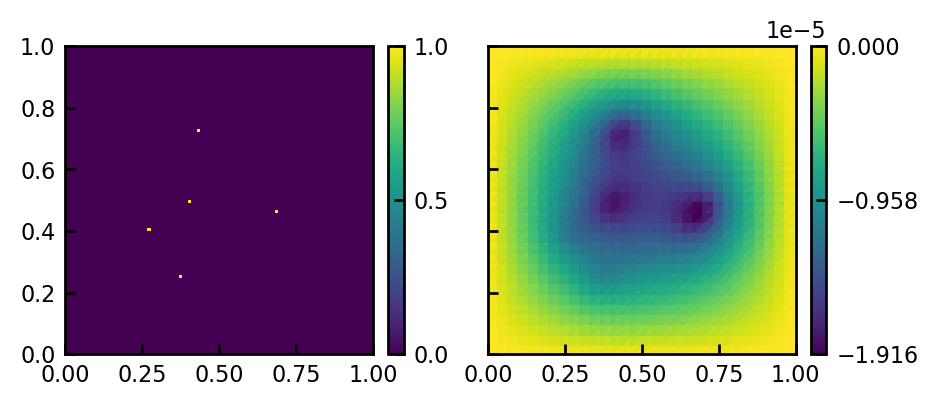

In [27]:
# Load dataset
from data_processing import HDF5Dataset, scalar_img_to_mesh

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
import dolfin as dlf
dlf.set_log_level(40)

dataset = HDF5Dataset()

fig, ax = plt.subplots(1, 2, figsize=(5,2), sharex=True, sharey=True)
sample = dataset[0]
plot_grid(sample['inputs'][2], sample['inputs'][:2], ax[0])
plot_mesh(sample['output'], dataset.mesh, ax[1])

# Check residual on Jhat
Jhat = sample['Jhat']
f = np.random.random(sample['output'].shape)
print(f'Loss with random inputs: {Jhat(f):.3g}')

f = scalar_img_to_mesh(sample['force'][0], sample['grid_x'], sample['grid_x'], dataset.build_problem.function_space, use_torch=False, vals_only=True)
print(f'Loss with assigned force: {Jhat(f):.3g}')

In [28]:
from dolfin_pbnn import DolfinPBNN
from data_processing import HDF5Dataset, scalar_img_to_mesh
from tqdm import tqdm
import logging
import dolfin as dlf
import dolfin_adjoint as d_ad

# Turn off annoying log messages
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

# Load dataset
dataset = HDF5Dataset()
print('Dataset length:', len(dataset))

# Load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DolfinPBNN().to(device)

# Build optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

idxs = np.arange(len(dataset), dtype=int)
num_epochs = 20
batch_size = 16

for epoch in range(10):
    np.random.shuffle(idxs)
    d_ad.set_working_tape(d_ad.Tape())

    epoch_loss = 0.

    for i in range(len(dataset)):
        sample = dataset[idxs[i]]
        sample['inputs'] = sample['inputs'][None].to(device)

        force, loss = model.training_step(sample)
        epoch_loss += loss
        
        if i % batch_size == 0:
            optimizer.step()
            d_ad.set_working_tape(d_ad.Tape())
            optimizer.zero_grad()

    print(f'Epoch {epoch}\tLoss = {loss:.3g}')

Dataset length: 512
Epoch 0	Loss = 6.52e-07


Loss with assigned force: 2.09e-07


(0.0, 1.0, 0.0, 1.0)

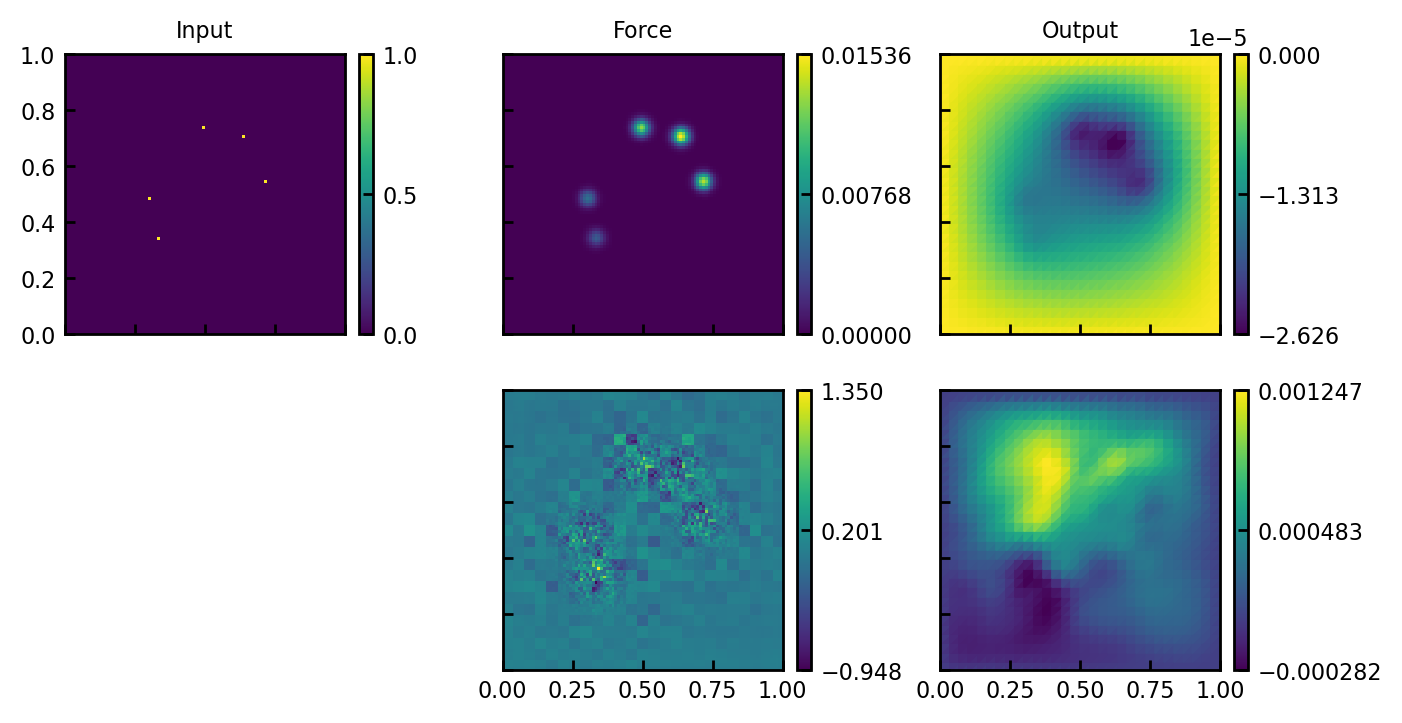

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(8,4), sharex=True, sharey=True, squeeze=False)
model.eval()
sample = dataset[0]
plot_grid(sample['inputs'][2], sample['inputs'][:2], ax[0,0])
plot_grid(sample['force'][0], sample['inputs'][:2], ax[0,1])
plot_mesh(sample['output'], dataset.mesh, ax[0,2])

force = model(sample['inputs'][None].to(device)).squeeze()
force = force.detach().cpu()
plot_grid(force, sample['inputs'][:2], ax[1,1])

force = scalar_img_to_mesh(
    force,
    sample['grid_x'], sample['grid_y'],
    sample['function_space'],
    vals_only=False
)
pred = dataset.build_problem.forward(force)
plot_mesh(pred.compute_vertex_values(), dataset.mesh, ax[1,2])

print(f'Loss with assigned force: {sample['Jhat'](force.vector()[:]):.3g}')

ax[0,0].set_title('Input')
ax[0,1].set_title('Force')
ax[0,2].set_title('Output')

ax[1,0].axis('off')
